In [1]:
import os
import sys
sys.path.append('../src')
import numpy as np

from generator import generate_samples
from utils import split_and_preprocess
from adjustment_methods import (
    get_ate_ols,
    get_ate_cuped,
    get_ate_cupac,
    get_ate_doubly_robust,
)

import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2

# Using the generator to generate some samples

### With no covariates

In [2]:
data = generate_samples(
    mu_metric=5,
    sigma_metric=1,
    epsilon=2,
    treatment_effect=1,
    size=10_000,
    cov_mu_eps=[],
    non_linear=[],
    p_binomial=0.1,
    seed=0,
)
data

,Y,T,Y_before,R_1
0,4.877997,0,4.382883,1.287700
1,1.334946,0,5.706182,-0.710599
2,3.968429,1,4.962774,0.214497
3,7.015296,0,5.417776,-0.956151
4,6.311648,0,5.272404,0.990580
...,...,...,...,...
9995,9.442465,0,5.440529,-0.323190
9996,2.671538,0,5.050690,0.044956
9997,1.541621,0,3.573520,0.488989
9998,2.462050,0,5.048884,2.200604


### With covariates

In [13]:
data = generate_samples(
    mu_metric=5,
    sigma_metric=1,
    epsilon=2,
    treatment_effect=2,
    size=10_000,
    cov_mu_eps=[(-1,1),(-2,1),(5,2)],
    non_linear=[False, False, True],
    p_binomial=0.5,
    seed=0,
)
data

,Y,T,Y_before,X_1,X_2,X_3,R_1
0,26.732167,1,3.936857,-1.163655,-0.540943,4.571790,0.763414
1,37.701593,0,4.185564,-1.025158,-0.968782,5.970232,1.330552
2,13.901865,0,3.888119,-0.606926,-1.991846,3.706255,-1.364600
3,40.332955,1,6.178844,-1.115551,-1.484831,6.096019,0.158547
4,62.274289,0,7.696119,0.741448,-1.502307,7.362789,0.017316
...,...,...,...,...,...,...,...
9995,57.472413,1,5.303162,-2.707667,-2.141857,7.317393,-0.676291
9996,23.796151,0,5.538354,-1.473631,-3.828844,4.629548,0.608841
9997,12.913443,1,6.014092,-1.543681,-4.097892,3.725694,-1.435856
9998,29.816313,1,5.580853,-0.886249,-2.579803,5.205852,-1.619453


# Getting a single ATE for this data

In [14]:
train_data, test_data = split_and_preprocess(data, treatment_effect=2)
len(train_data), len(test_data)

(5000, 5000)

# Mean Diff

In [15]:
test_data.loc[test_data['T']==1, 'Y'].mean() - test_data.loc[test_data['T']==0, 'Y'].mean()

1.675298511359017

### CUPED

Only uses outcome pre experiment

In [16]:
get_ate_cuped(test_data)

1.6509293548894028

### Multivariable regression

In [17]:
get_ate_ols(test_data, covariates=["Y_before", "X_1", "X_2", "X_3"])

1.7196098201154364

### CUPAC

In [18]:
get_ate_cupac(test_data, train_data, covariates=["Y_before", "X_1", "X_2", "X_3"])

2.035720650321572

### Doubly Robust

In [19]:
get_ate_doubly_robust(test_data, covariates=["Y_before", "X_1", "X_2", "X_3"])

1.674608798947819

## Simulating the experiment many times, supposing only linear effects

$$\epsilon \sim N(0,2)$$
$$Y_0 \sim N(20,10)$$
$$X_1 \sim N(-1,-1)$$
$$X_2 \sim N(-2,1)$$
$$X_3 \sim N(5,5)$$

$$Y = Y_0 + 0.1*T + X_1 + X_2 + X_3 + \epsilon$$

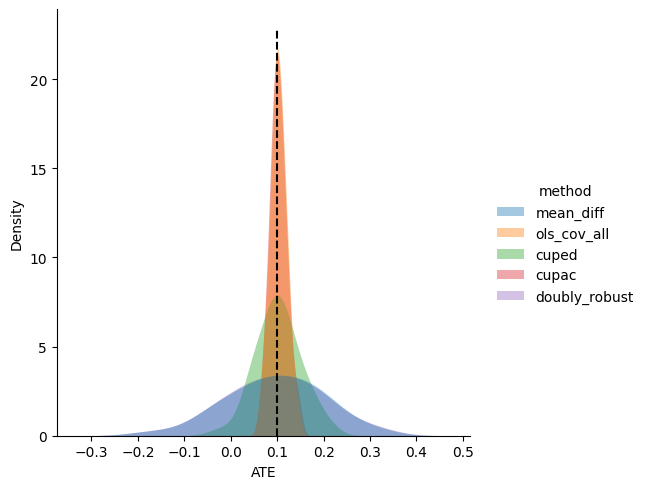

,method,mse
0,cupac,0.000309
1,cuped,0.002330
2,doubly_robust,0.011005
3,mean_diff,0.010825
4,ols_cov_all,0.000297


In [10]:
ate = []
ate_cuped = []
ate_ols_cov = []
ate_cupac = []
ate_doubly_robust = []

N_SAMPLES = 100_000
N_SIMULATIONS = 100
REAL_ATE = 0.1

for i in range(N_SIMULATIONS):
    data = generate_samples(
        mu_metric=20,
        sigma_metric=10,
        epsilon=2,
        treatment_effect=REAL_ATE,
        size=N_SAMPLES,
        cov_mu_eps=[(-1,1),(-2,1),(5,5)],
    )

    pre_analysis_data, analysis_data = split_and_preprocess(data, REAL_ATE)
    ate_cupac.append(get_ate_cupac(analysis_data, pre_analysis_data, covariates=['Y_before', 'X_1', 'X_2', 'X_3']))
    ate.append(analysis_data.loc[analysis_data['T']==1, 'Y'].mean() - analysis_data.loc[analysis_data['T']==0, 'Y'].mean())
    ate_ols_cov.append(get_ate_ols(analysis_data, covariates=['Y_before', 'X_1', 'X_2', 'X_3']))
    ate_cuped.append(get_ate_cuped(analysis_data))
    ate_doubly_robust.append(get_ate_doubly_robust(analysis_data, covariates=['Y_before', 'X_1', 'X_2', 'X_3']))

results = pd.DataFrame({
    'mean_diff': ate,
    'ols_cov_all': ate_ols_cov,
    'cuped': ate_cuped,
    'cupac': ate_cupac,
    'doubly_robust': ate_doubly_robust,
}).stack(level=0).reset_index(level=1, name='ATE').rename({'level_1': 'method'}, axis=1).reset_index(drop=True)
errors = pd.DataFrame({
    'mean_diff': (np.array(ate) - REAL_ATE)**2,
    'ols_cov_all': (np.array(ate_ols_cov) - REAL_ATE)**2,
    'cuped': (np.array(ate_cuped) - REAL_ATE)**2,
    'cupac': (np.array(ate_cupac) - REAL_ATE)**2,
    'doubly_robust': (np.array(ate_doubly_robust) - REAL_ATE)**2,
}).stack(level=0).reset_index(level=1, name='ATE').rename({'level_1': 'method'}, axis=1).reset_index(drop=True)


sns.displot(x='ATE',data=results, fill=True, kind='kde', hue='method', common_norm=False, alpha=.4, linewidth=0, bw_adjust=1.2);
plt.vlines(REAL_ATE, plt.ylim()[0], plt.ylim()[1], linestyles="dashed", label='ATE',colors='k');
plt.show()
errors.groupby('method').agg(mse=('ATE', 'mean')).reset_index()

## Now simulating the same linear process, but using only a random variable as a covariate

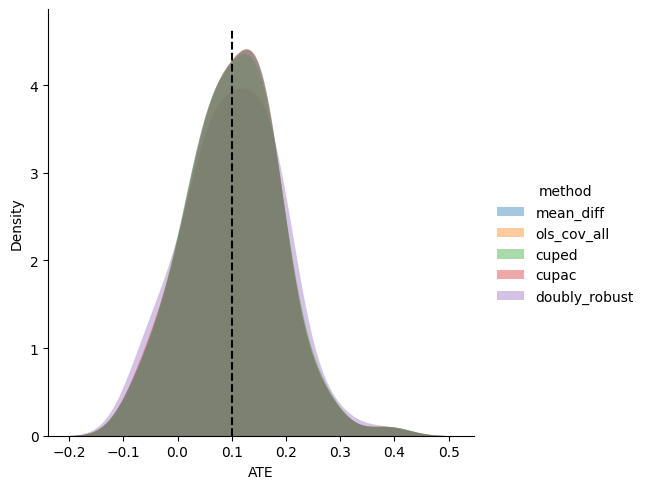

,method,mse
0,cupac,0.006822
1,cuped,0.006847
2,doubly_robust,0.007680
3,mean_diff,0.006825
4,ols_cov_all,0.006822


In [11]:
ate = []
ate_cuped = []
ate_ols_cov = []
ate_cupac = []
ate_doubly_robust = []

N_SAMPLES = 100_000
N_SIMULATIONS = 100
REAL_ATE = 0.1

for i in range(N_SIMULATIONS):
    data = generate_samples(
        mu_metric=20,
        sigma_metric=10,
        epsilon=2,
        treatment_effect=REAL_ATE,
        size=N_SAMPLES,
        cov_mu_eps=[(-1,1),(-2,1),(5,2)],
    )

    pre_analysis_data, analysis_data = split_and_preprocess(data, REAL_ATE)
    ate_cupac.append(get_ate_cupac(analysis_data, pre_analysis_data, covariates=['R_1']))
    ate.append(analysis_data.loc[analysis_data['T']==1, 'Y'].mean() - analysis_data.loc[analysis_data['T']==0, 'Y'].mean())
    ate_ols_cov.append(get_ate_ols(analysis_data, covariates=['R_1']))
    ate_cuped.append(get_ate_cuped(analysis_data, prediction_column='R_1'))
    ate_doubly_robust.append(get_ate_doubly_robust(analysis_data, covariates=['R_1']))

results = pd.DataFrame({
    'mean_diff': ate,
    'ols_cov_all': ate_ols_cov,
    'cuped': ate_cuped,
    'cupac': ate_cupac,
    'doubly_robust': ate_doubly_robust,
}).stack(level=0).reset_index(level=1, name='ATE').rename({'level_1': 'method'}, axis=1).reset_index(drop=True)
errors = pd.DataFrame({
    'mean_diff': (np.array(ate) - REAL_ATE)**2,
    'ols_cov_all': (np.array(ate_ols_cov) - REAL_ATE)**2,
    'cuped': (np.array(ate_cuped) - REAL_ATE)**2,
    'cupac': (np.array(ate_cupac) - REAL_ATE)**2,
    'doubly_robust': (np.array(ate_doubly_robust) - REAL_ATE)**2,
}).stack(level=0).reset_index(level=1, name='ATE').rename({'level_1': 'method'}, axis=1).reset_index(drop=True)


sns.displot(x='ATE',data=results, fill=True, kind='kde', hue='method', common_norm=False, alpha=.4, linewidth=0, bw_adjust=1.2);
plt.vlines(REAL_ATE, plt.ylim()[0], plt.ylim()[1], linestyles="dashed", label='ATE',colors='k');
plt.show()
errors.groupby('method').agg(mse=('ATE', 'mean')).reset_index()

## Simulating now with non-linear effects

$$\epsilon \sim N(0,2)$$
$$Y_0 \sim N(20,10)$$
$$X_1 \sim N(-1,-1)$$
$$X_2 \sim N(-2,1)$$
$$X_3 \sim N(5,5)$$

$$Y = Y_0 + 0.1*T + X_1 + X_2 + X_3^2 + \epsilon$$

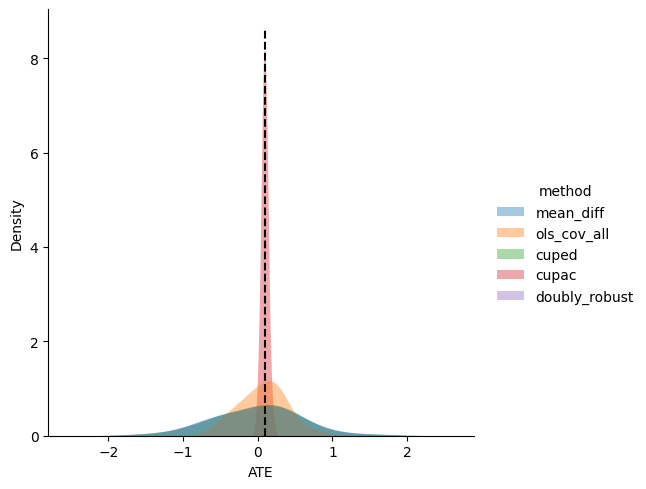

,method,mse
0,cupac,0.002051
1,cuped,0.347158
2,doubly_robust,0.359015
3,mean_diff,0.361417
4,ols_cov_all,0.100884


In [12]:
ate = []
ate_cuped = []
ate_ols_cov = []
ate_cupac = []
ate_doubly_robust = []

N_SAMPLES = 100_000
N_SIMULATIONS = 100
REAL_ATE = 0.1

for i in range(N_SIMULATIONS):
    data = generate_samples(
        mu_metric=20,
        sigma_metric=10,
        epsilon=2,
        treatment_effect=REAL_ATE,
        size=N_SAMPLES,
        cov_mu_eps=[(-1,1),(-2,1),(5,5)],
        non_linear=[False, False, True]
    )

    pre_analysis_data, analysis_data = split_and_preprocess(data, REAL_ATE)
    ate_cupac.append(get_ate_cupac(analysis_data, pre_analysis_data, covariates=['Y_before', 'X_1', 'X_2', 'X_3']))
    ate.append(analysis_data.loc[analysis_data['T']==1, 'Y'].mean() - analysis_data.loc[analysis_data['T']==0, 'Y'].mean())
    ate_ols_cov.append(get_ate_ols(analysis_data, covariates=['Y_before', 'X_1', 'X_2', 'X_3']))
    ate_cuped.append(get_ate_cuped(analysis_data))
    ate_doubly_robust.append(get_ate_doubly_robust(analysis_data, covariates=['Y_before', 'X_1', 'X_2', 'X_3']))

results = pd.DataFrame({
    'mean_diff': ate,
    'ols_cov_all': ate_ols_cov,
    'cuped': ate_cuped,
    'cupac': ate_cupac,
    'doubly_robust': ate_doubly_robust,
}).stack(level=0).reset_index(level=1, name='ATE').rename({'level_1': 'method'}, axis=1).reset_index(drop=True)
errors = pd.DataFrame({
    'mean_diff': (np.array(ate) - REAL_ATE)**2,
    'ols_cov_all': (np.array(ate_ols_cov) - REAL_ATE)**2,
    'cuped': (np.array(ate_cuped) - REAL_ATE)**2,
    'cupac': (np.array(ate_cupac) - REAL_ATE)**2,
    'doubly_robust': (np.array(ate_doubly_robust) - REAL_ATE)**2,
}).stack(level=0).reset_index(level=1, name='ATE').rename({'level_1': 'method'}, axis=1).reset_index(drop=True)


sns.displot(x='ATE',data=results, fill=True, kind='kde', hue='method', common_norm=False, alpha=.4, linewidth=0, bw_adjust=1.2);
plt.vlines(REAL_ATE, plt.ylim()[0], plt.ylim()[1], linestyles="dashed", label='ATE',colors='k');
plt.show()
errors.groupby('method').agg(mse=('ATE', 'mean')).reset_index()